In [10]:
import os
from time import time
import yaml

from argparse import ArgumentParser, Namespace

from s3ts.api.nets.wrapper import WrapperModel
from s3ts.helper_functions import load_dm, str_time, get_parser

from pytorch_lightning import Trainer
from pytorch_lightning.utilities.model_summary import summarize

from s3ts.helper_functions import get_model

import torch
import numpy as np
from torch import nn, Tensor

import matplotlib.pyplot as plt

In [11]:
from s3ts.api.nets.transformer import TransformerWrapper

In [12]:
p = get_parser()
args = p.parse_args("--mode ts --dataset UCI-HAR --lr 0.001 --subjects_for_test 21 --window_size 32 --window_stride 2 --batch_size 128 --encoder_architecture cnn_gap --encoder_features 20 --decoder_architecture mlp --decoder_features 32 --decoder_layers 1 --pattern_size 32 --rho 0.1 --compute_n 300 --pattern_type fftvar --num_workers 8 --max_epochs 3 --normalize --reduce_imbalance --training_dir training_cv2 --n_val_subjects 4 --weight_decayL1 0 --weight_decayL2 0".split())

In [13]:
dm = load_dm(args)

# class_changes = [0] + list(np.nonzero(np.diff(dm.stsds.SCS))[0])
# print(len(class_changes), "number of class changes")

Loaded dataset UCI-HAR with a total of 815614 observations for window size 32
Sampling 59084 (balanced) observations per epoch.
Using 708997 observations for training, 106617 for validation and 25512 observations for test


In [14]:
import pywt as wt

In [33]:
data = dm.stsds[1000]

In [34]:
data[0].shape

torch.Size([6, 32])

In [47]:
np.arange(1, data[0].shape[1]+1, dtype=np.float64)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32.])

In [75]:
from s3ts.api.wavelets import *

In [100]:
transform = CWT(dt=1/320)

In [101]:
res2 = transform(dm.stsds[2000][0].unsqueeze(0))

In [102]:
res2.shape

torch.Size([1, 6, 49, 32])

In [104]:
res = wt.cwt(dm.stsds[2000][0].numpy(), scales=np.arange(1, data[0].shape[1]+1, dtype=np.float64)/2, sampling_period=1, wavelet="morl")[0]

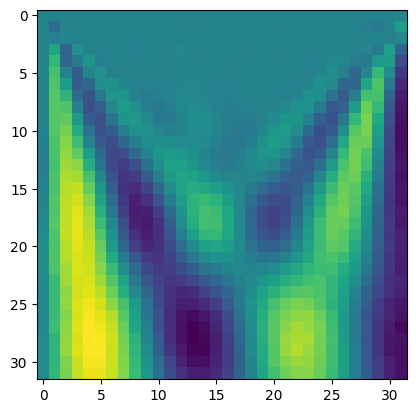

In [106]:
plt.imshow(res[:,1,:])

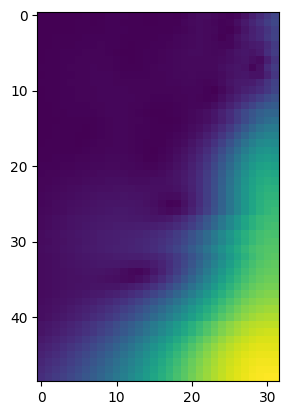

In [103]:
plt.imshow(res2[0, 5, :, :])

In [5]:
model = TransformerWrapper(
    dsrc="ts",
    n_dims=6,
    n_classes=12,
    wdw_len=32,
    wdw_str=2,
    latent_dims=32,
    transformer_layers=4,
    feedforward_mult=2,
    n_heads=8,
    dropout=0.1,
    lr=0.0001,
    voting={"rho": 0.1, "n": 1},
    weight_decayL1=0.0001,
    weight_decayL2=1e-5,
    name="test",
    args=None
)

In [6]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer, seed_everything

In [7]:

def train_transformer(
        dm, 
        model: TransformerWrapper,
        max_epochs: int,
        ) -> tuple[TransformerWrapper, dict]:
    print(model.name)

    # reset the random seed
    seed_everything(42, workers=True)

    # set up the trainer
    ckpt = ModelCheckpoint(
        monitor="val_re", 
        mode="max",
        save_top_k=-1,
        filename='{epoch}-{step}-{val_re:.2f}'
    )
    print(model.name)
    tr = Trainer(default_root_dir="./training", 
        accelerator="auto", callbacks=[ckpt, LearningRateMonitor(logging_interval="epoch")], max_epochs=max_epochs,
        logger=TensorBoardLogger(save_dir="./training", name=model.name.replace("|", "_").replace(",", "_")))

    # train the model
    tr.fit(model=model, datamodule=dm)

    # load the best weights
    model = TransformerWrapper.load_from_checkpoint(ckpt.best_model_path)

    # run the validation with the final weights
    data = tr.test(model, datamodule=dm)

    return model, data[0]

In [9]:
print(model.name)
train_transformer(dm, model, 2)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type                      | Params
----------------------------------------------------------
0 | transformer | TimeSeriesTransformer     | 34.8 K
1 | flatten     | Flatten                   | 0     
2 | softmax     | Softmax                   | 0     
3 | train_cm    | MulticlassConfusionMatrix | 0     
4 | val_cm      | MulticlassConfusionMatrix | 0     
5 | val_auroc   | MulticlassAUROC           | 0     
6 | test_cm     | MulticlassConfusionMatrix | 0     
7 | test_auroc  | MulticlassAUROC           | 0     
----------------------------------------------------------
34.8 K    Trainable params
0         Non-trainable params
34.8 K    Total params
0.139     Total estimated model params size (MB)


test
test
test
Testing DataLoader 0: 100%|██████████| 200/200 [00:04<00:00, 42.27it/s]ain_loss_step=1.430, val_loss_step=1.380, val_loss_epoch=1.390, val_re=0.473, val_auroc=0.898, train_loss_epoch=1.950, train_re=0.362]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_auroc         │    0.9130134582519531     │
│          test_f1          │    0.5859946608543396     │
│         test_iou          │    0.42831742763519287    │
│      test_loss_epoch      │    1.2478026151657104     │
│          test_pr          │    0.6318081021308899     │
│          test_re          │    0.5354869961738586     │
└───────────────────────────┴───────────────────────────┘

(TransformerWrapper(
   (transformer): TimeSeriesTransformer(
     (embedding): Linear(in_features=6, out_features=32, bias=True)
     (positional_encoder): PositionalEncoding(
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (decoder_output): Linear(in_features=32, out_features=12, bias=True)
     (encoder): TransformerEncoder(
       (layers): ModuleList(
         (0-3): 4 x TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
           )
           (linear1): Linear(in_features=32, out_features=64, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
           (linear2): Linear(in_features=64, out_features=32, bias=True)
           (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
           (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropou